In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import skimage.io as skio
import openslide

## Get Whole Slide Image

Convert scanned digital slides of .svs into .png format using openslide

In [1]:
# read slides in .svs from dir 
slidelist = os.listdir("./slides")

for slidei in slidelist[:]:
    print(slidei)
    idi = slidei.split('_')[0]
    
    # open slide.svs
    slide_0 = openslide.OpenSlide('./slides/{}'.format(slidei))
    levels = slide_0.level_dimensions
    print("stored slide size pyramid",levels)

    # fetch levels[2] size of whole WSI region 
    slide = slide_0.read_region((0,0),2,levels[2])
    slide = np.asarray(slide)
    print("fetched shape",slide.shape)

    # origin slide is in RGBA format, convert it to RGB and save to model data dir
    slide = cv2.cvtColor(slide, cv2.COLOR_RGBA2RGB)
    skio.imsave('../data/WSI/slide_{}.png'.format(idi),slide.astype("uint8"))
    plt.imshow(slide)
    plt.show()

NameError: name 'os' is not defined

## Get Whole Slide Mask

Convert annotations of objects into binary mask, usually reconstruct from contour line locations or contour mask images  

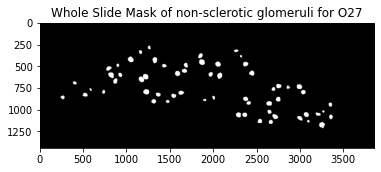

In [ ]:
# display one result mask
idi = "O27"
mask = skio.imread('../data/WSI/mask_{}.png'.format(idi))
plt.imshow(mask,cmap="gray")
plt.title("Whole Slide Mask of non-sclerotic glomeruli for {}".format(idi))
plt.show()

## Get training/testing patches

Extract fixed size random patches of slide and mask from whole slide region for model training/testing  

In [2]:
# return a mask patch with start location
def random_crop_mask(mask, crop_size):
    (height, width) = mask.shape
    dx = crop_size
    dy = crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    mask_extract = mask[y:(y+dy), x:(x+dx)]
    return  mask_extract, y, x

In [12]:
slidelist = os.listdir("./slides")
for slidei in slidelist[:]:
    idi = slidei.split('_')[0]
    print(idi)
    
    # create folder for extracted patches of one whole slide
    dirname = './masks_patch/{}'.format(idi)
    os.mkdir(dirname)
    dirname = './slides_patch/{}'.format(idi)
    os.mkdir(dirname)
    
    # read whole slide
    slide = skio.imread('../data/WSI/slide_{}.png'.format(idi))
    mask = skio.imread('../data/WSI/mask_{}.png'.format(idi))[:,:,0]/255
   
    # extract patches
    cnt = 0
    crop_size = 256
    batch = 500
    for i in range(batch):
        mask_extract, y, x = random_crop_mask(mask, crop_size)
        area = np.sum(mask_extract)
        
        # choose patch of region containing some parts of glom object (mask=1)
        if area > 500:  # a good patch to extract, area can be adjusted  
            cnt += 1 
            region_extract = slide[y:y+crop_size,x:x+crop_size]
            
            # record patch id and location
            skio.imsave('./masks_patch/{}/mask_{}_{}_{}_{}.png'.format(idi,idi,cnt,y,x), mask_extract.astype(np.uint8)*255)
            skio.imsave('./slides_patch/{}/slide_{}_{}_{}_{}.png'.format(idi,idi,cnt,y,x), region_extract)
        # limit patch numbers for one slide
        if(cnt>=50): 
            break
    print('# of patches:',cnt)

O27
# of patches: 50
